In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from small2DNet import small2DNet
from util import add_color, colorize, colorize_gaussian, calculate_correct_loss
from colorMNist import colorMNist
import random
import colorsys
import pickle

In [2]:
# Load data
mnist_train = torchvision.datasets.MNIST('datasets/mnist', train=True, download=False, transform=torchvision.transforms.Compose([
                                                    torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Lambda(add_color),
                                                    # torchvision.transforms.Normalize(
                                                    #     [0.1307, 0.1307, 0.1307], [0.3081, 0.3081, 0.3081])
                                                    ]))
mnist_test = torchvision.datasets.MNIST('datasets/mnist', train=False, download=False, transform=torchvision.transforms.Compose([
                                                    torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Lambda(add_color),
                                                    # torchvision.transforms.Normalize(
                                                    #     [0.1307, 0.1307, 0.1307], [0.3081, 0.3081, 0.3081])
                                                    ]))

In [19]:
# Color dict
colorless_dict = {}
deterministic_dict = {0: [[255, 0, 0]], 1: [[255, 153, 0]], 2: [[204, 255, 0]], 3: [[51, 255, 0]], 4: [[0, 255, 102]],
              5: [[0, 255, 255]], 6: [[0, 102, 255]], 7: [[51, 0, 255]], 8: [[204, 0, 255]], 9: [[255, 0, 153]]}
colors = [[255, 0, 0], [255, 153, 0], [204, 255, 0], [51, 255, 0], [0, 255, 102], [0, 255, 255], [0, 102, 255],
         [51, 0, 255], [204, 0, 255], [255, 0, 153]]
uniform_dict = {}
for i in range(10):
    uniform_dict[i] = colors
gaussian_dict = {0: 0, 1: 36, 2: 72, 3: 108, 4: 144, 5: 180, 6: 216, 7: 252, 8: 288, 9: 324, 10: 0}

# Choose the right dictionary for the run
color_dict = uniform_dict

In [20]:
# The filtered dataset
trimmed_dataset = torch.utils.data.Subset(mnist_train, range(5000))

# Filtered test dataset
test_dataset = torch.utils.data.Subset(mnist_test, range(len(mnist_test)))

# Create the 80/20 train/val split
train_split = int(0.8 * len(trimmed_dataset))
# Train dataset
train_dataset = torch.utils.data.Subset(trimmed_dataset, [i for i in range(train_split)])
# Validation dataset
val_dataset = torch.utils.data.Subset(trimmed_dataset, [i for i in range(train_split, len(trimmed_dataset))])
print(len(train_dataset), len(val_dataset), len(train_dataset) + len(val_dataset), len(trimmed_dataset), len(test_dataset))

4000 1000 5000 5000 10000


In [ ]:
image = train_dataset[0][0]
label = train_dataset[0][1]
image, hue = colorize_gaussian(image, label, gaussian_dict)
print(hue)
plt.imshow(image.permute(1, 2, 0))

In [21]:
colormnist_train = []
colormnist_val = []
colormnist_test = []
tfms = torchvision.transforms.Normalize([0.1307, 0.1307, 0.1307], [0.3081, 0.3081, 0.3081])
for x in train_dataset:
    image = x[0]
    label = x[1]
    
    image, color = colorize(image, label, color_dict)
    colormnist_train.append([image, color])
    
colormnist_val = []
for x in val_dataset:
    image = x[0]
    label = x[1]
    
    image, color = colorize(image, label, color_dict)
    colormnist_val.append([image, color])
    
colormnist_test = []
for x in test_dataset:
    image = x[0]
    label = x[1]
    
    image, color = colorize(image, label, color_dict)
    colormnist_test.append([image, color])

In [22]:
pickle.dump([colormnist_train, colormnist_val, colormnist_test], open("custom_datasets/5k/color_uniform.pkl", "wb"))

In [23]:
cmnist_train, cmnist_val, cmnist_test = pickle.load(open("custom_datasets/5k/color_uniform.pkl", "rb"))

In [24]:
cmnist_tr = colorMNist(cmnist_train)
cmnist_va = colorMNist(cmnist_val)
cmnist_te = colorMNist(cmnist_test)

In [25]:
# Dataloaders
train_dataloader = torch.utils.data.DataLoader(cmnist_tr, batch_size=32, shuffle=False, num_workers = 0)
val_dataloader = torch.utils.data.DataLoader(cmnist_va, batch_size=32, shuffle=False, num_workers = 0)
test_dataloader = torch.utils.data.DataLoader(cmnist_te, batch_size=32, shuffle=False, num_workers = 0)

  0%|          | 0/313 [00:00<?, ?it/s]

tensor([4, 5, 7, 7, 3, 4, 0, 2, 0, 5, 0, 7, 1, 7, 1, 5, 3, 3, 8, 1, 1, 5, 7, 0,
        9, 3, 4, 9, 0, 1, 4, 6])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

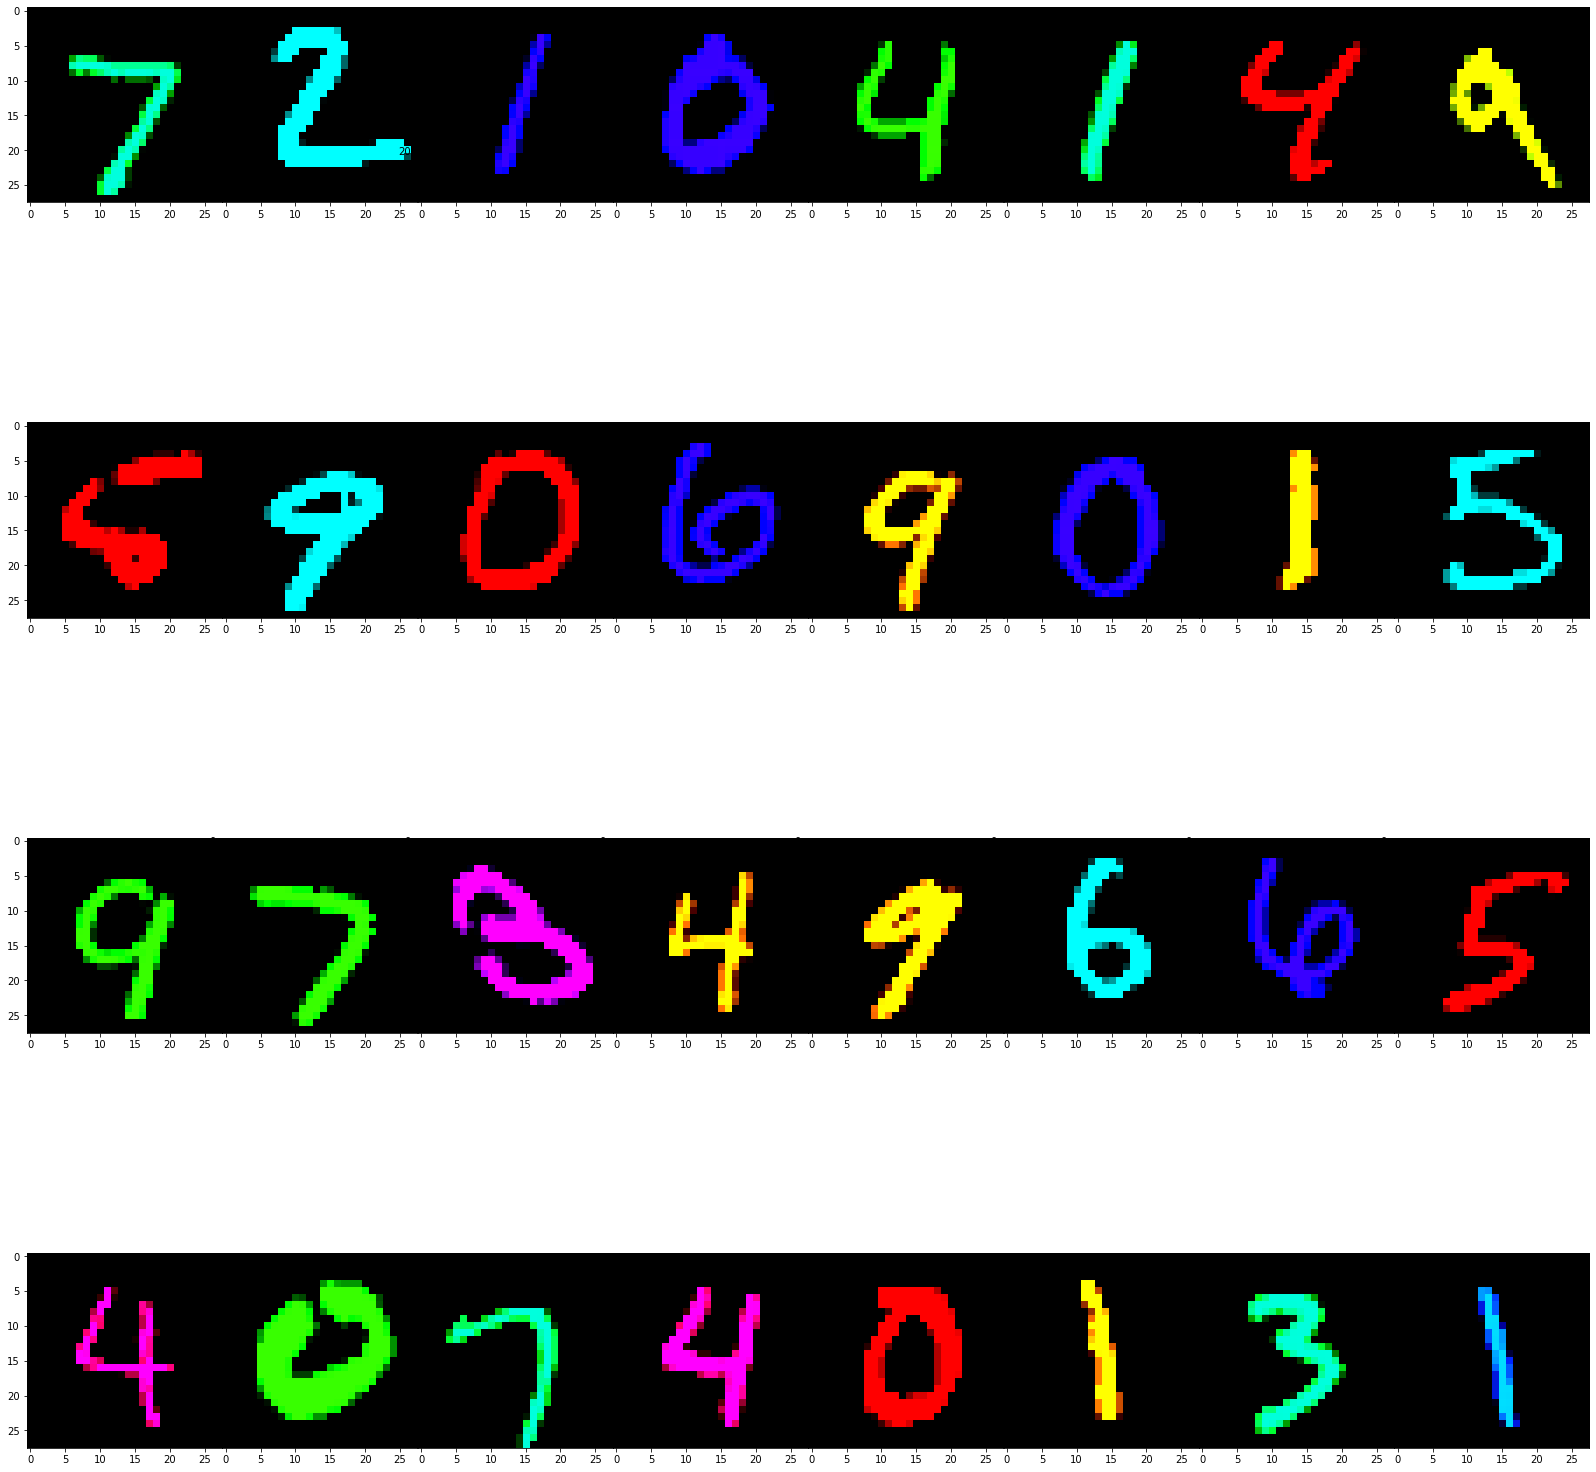

In [26]:
for (images, labels) in tqdm(test_dataloader):
    print(labels)
    # Show batch images
    fig, axs = plt.subplots(4,8, figsize=(28, 28), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    for i in range(len(images)):
        new_image = images[i]
        # new_image = tfms(new_image)
        axs[i].imshow(new_image.permute(1, 2, 0))
    break

In [ ]:
for (images, labels) in tqdm(test_dataloader):
    print(labels)
    # Show batch images
    fig, axs = plt.subplots(4,8, figsize=(28, 28), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    # tfms = transforms.Compose(
    #     [transforms.Grayscale(num_output_channels=1), transforms.ToTensor(),
    #      transforms.Normalize(mean=[0.5], std=[0.5])])
    for i in range(len(images)):
        new_image = images[i]
        # new_image = tfms(new_image)
        axs[i].imshow(new_image.permute(1, 2, 0))
    break

In [ ]:
count_dict = {}
for i in range(10):
    count_dict[i] = 0
for (images, labels) in tqdm(val_dataloader):
    for i in range(len(images)):
        count_dict[labels[i].item()] += 1
        # if labels[i] == 0:
        #     new_image = images[i]
        #     plt.imshow(new_image.permute(1, 2, 0))
        #     plt.show()
        
print(count_dict)

In [ ]:
cmnist_train, cmnist_val, cmnist_test = pickle.load(open("Old/old_custom_datasets/5k/color_uniform.pkl", "rb"))
cmnist_tr = colorMNist(cmnist_train)
cmnist_va = colorMNist(cmnist_val)
cmnist_te = colorMNist(cmnist_test)
train_dataloader = torch.utils.data.DataLoader(cmnist_tr, batch_size=32, shuffle=False, num_workers = 0)
val_dataloader = torch.utils.data.DataLoader(cmnist_va, batch_size=32, shuffle=False, num_workers = 0)
test_dataloader = torch.utils.data.DataLoader(cmnist_te, batch_size=32, shuffle=False, num_workers = 0)
count_dict = {}
for i in range(10):
    count_dict[i] = 0
for (images, labels) in tqdm(train_dataloader):
    for i in range(len(images)):
        # count_dict[labels[i].item()] += 1
        if labels[i] == 5:
            new_image = images[i]
            # tfms = torchvision.transforms.Normalize([0.1307, 0.1307, 0.1307], [0.3081, 0.3081, 0.3081])
            # new_image = tfms(new_image)
            plt.imshow(new_image.permute(1, 2, 0))
            plt.show()
        
print(count_dict)